In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tqdm
from tqdm.keras import TqdmCallback

from src.ml.ml_reg import MLP_Model
from src.ml.ml_reg import LSTM_Model
import src

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "figure.dpi": 100,
})
%matplotlib inline

In [3]:
exps = ['Test 11',
        'Test 14',
        'Test 15',
        'Test 16',
        'Test 17',
        'Test 18',
        'Test 19',
        ]
exps = [src.load(exp) for exp in exps]
dfs = [exp.features.iloc[1:] for exp in exps]

In [4]:
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout',
                                'Form error',
                                'Peak radius',
                                'Radius diff',
                                # 'Mean radius',
                                # 'Avg probe',
                                'Probe diff',
                                ])#.drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 960 rows x 9 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius,Avg probe
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393,16.873432,0.672499,0.0002
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281,39.609882,0.671830,0.0049
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164,47.254065,0.669854,0.0399
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557,48.616375,0.668865,0.0778
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365,48.321941,0.668145,0.1089


In [5]:
def pred_plot(y: np.ndarray,
              y_pred: np.ndarray,
              title: str = '',
              ):
    assert y.shape == y_pred.shape, 'y and y_pred must have the same shape'

    if y.ndim == 1:
        y = y.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    n_outputs = y.shape[1]

    fig, ax = plt.subplots(n_outputs, 2, figsize=(5 * n_outputs, 5 * 2))

    for i in range(n_outputs):
        ax[i, 0].scatter(y[:, i], y_pred[:, i])
        lims = [
            np.min([ax[i, 0].get_xlim(), ax[i, 0].get_ylim()]),
            np.max([ax[i, 0].get_xlim(), ax[i, 0].get_ylim()]),
        ]
        ax[i, 0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax[i, 0].grid()
        ax[i, 0].set_aspect('equal')
        ax[i, 0].set_xlim(lims)
        ax[i, 0].set_ylim(lims)
        ax[i, 0].set_xlabel('Actual Y')
        ax[i, 0].set_ylabel('Predicted Y')
        ax[i, 0].set_title(f'{title} - Output {i} Preds')

        diff = (y_pred[:, i] - y[:, i]) * 1000

        ax[i, 1].hist(diff, bins=30)
        ax[i, 1].set_xlabel('Prediction Error / um')
        ax[i, 1].set_ylabel('No Occurances')
        ax[i, 1].set_title(f'{title} - Output {i} Hist')
   
    fig.tight_layout()

In [6]:
input_df = main_df.iloc[:, :-2]
print(f'Input df : {input_df.shape[0]} rows x {input_df.shape[1]} cols')
input_df.head()

Input df : 960 rows x 7 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz
0,0.039208,15.358375,1.581795,0.019882,29.507773,36.712393,16.873432
1,0.289873,11.720536,8.527955,0.061386,31.941039,52.078281,39.609882
2,0.720448,6.666400,7.369736,-0.095615,36.136609,61.848164,47.254065
3,0.949587,5.552429,9.247926,-0.085875,35.081427,66.172557,48.616375
4,0.974782,5.480675,8.517215,-0.073499,34.281257,66.067365,48.321941


In [7]:
target_df = main_df.iloc[:, -2:]
print(f'Target df : {target_df.shape[0]} rows x {target_df.shape[1]} cols')
target_df.head()

Target df : 960 rows x 2 cols


,Mean radius,Avg probe
0,0.672499,0.0002
1,0.671830,0.0049
2,0.669854,0.0399
3,0.668865,0.0778
4,0.668145,0.1089


### MLP

In [24]:
mlp = MLP_Model(modelParams={'nLayers': 3,
                             'nUnits': [128, 128, 128],
                             'activation': 'relu',
                             'dropout': 0.1,
                             },
                compileParams={'optimizer': 'adam',
                               'loss': 'mse',
                               'metrics': ['root_mean_squared_error',
                                           'mean_absolute_error',
                                           'r2_score'
                                           ],
                               },
                inputData=input_df.values,
                targetData=target_df.values,
                testFrac=0.2,
                shuffle=True,
                randomState=42,
                tb=True,
                tbLogDir='NewCodeTest',
                )

In [25]:
mlp.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,306 (134.01 KB)

 Trainable params: 34,306 (134.01 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
mlp.fit(x=mlp.trainData[0],
        y=mlp.trainData[1],
        epochs=2000,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        )

  0%|          | 0/2000 [00:00<?, ?epoch/s]C:\Users\tomje\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'mlp__model_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
100%|██████████| 2000/2000 [05:45<00:00,  5.79epoch/s, loss=0.00715, mean_absolute_error=0.0338, r2_score=0.949, root_mean_squared_error=0.0845, val_loss=0.153, val_mean_absolute_error=0.12, val_r2_score=0.604, val_root_mean_squared_error=0.392]    


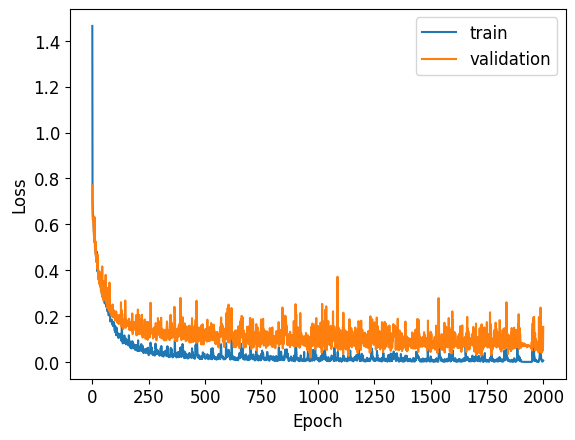

In [27]:
fig, ax = mlp.plot_loss()

In [28]:
y_pred = mlp.predict(x=mlp.testData[0])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


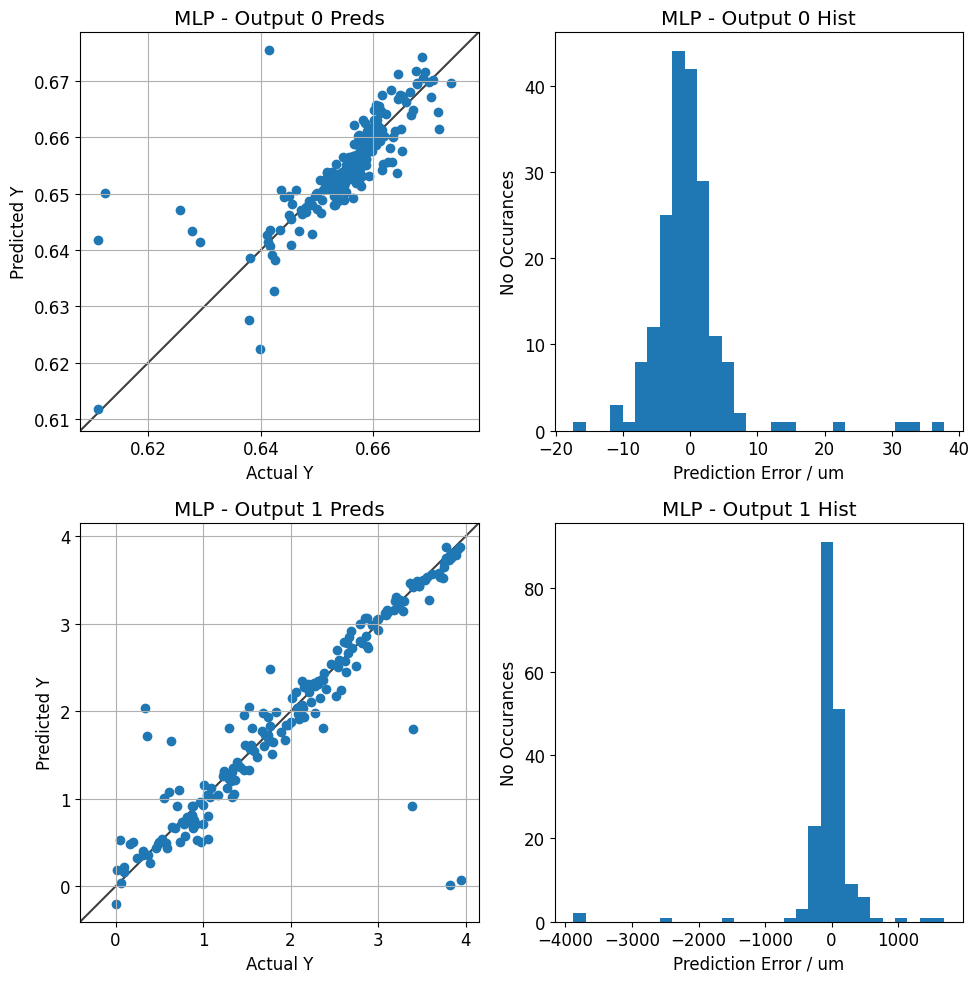

In [29]:
pred_plot(mlp.testData[1], y_pred, 'MLP')

In [30]:
sc = mlp.score(printout=True)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Data - Combined Outputs:
	mean_squared_error: 0.1305
	root_mean_squared_error: 0.3613
	mean_absolute_error: 0.1053
	r2_score: 0.6941

Test Data - Individual Outputs:
Output 1:
	mean_squared_error: 0.0000
	root_mean_squared_error: 0.0060
	mean_absolute_error: 0.0034
	r2_score: 0.6047
Output 2:
	mean_squared_error: 0.2611
	root_mean_squared_error: 0.5109
	mean_absolute_error: 0.2071
	r2_score: 0.7832


### LSTM

In [33]:
lstm = LSTM_Model(modelParams={'seqLen': 5,
                             'nLayers': 3,
                             'nUnits': [128, 128, 128],
                             'activation': 'relu',
                             'dropout': 0.1,
                             },
                  compileParams={'optimizer': 'adam',
                                 'loss': 'mse',
                                 'metrics': ['root_mean_squared_error',
                                             'mean_absolute_error',
                                             'r2_score'
                                             ],
                                 },
                  inputData=input_df.values,
                  targetData=target_df.values,
                  testFrac=0.2,
                  shuffle=True,
                  randomState=42,
                  tb=False,
                  tbLogDir='NewCodeTest',
                  )